In [1]:
import numpy as np
from Agent import Agent
import tensorflow as tf
import matplotlib.pyplot as plt


2024-02-27 20:13:04.228330: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 20:13:04.288168: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 20:13:04.288251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 20:13:04.292248: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 20:13:04.311369: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 20:13:04.312351: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
MAX_EPI = 5000
epsilon_update_freq = 500
MAX_STEPS = 100
GAMMA = 1.0
LEARNING_RATE = 0.01

reward_per_episode = []
avg_reward_per_episode = []
reward_avg = 0
weight_update_interval = 1000
agent = Agent(lr=LEARNING_RATE, gamma=GAMMA, output_dims=4,  # type: ignore
              batch_size=32, input_dims=2, mem_size=1000, fname="dqn_model_5_b32_lr001.keras")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 4)                 44        
                                                                 
Total params: 74 (296.00 Byte)
Trainable params: 74 (296.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                30        
                                                                 
 dense_3 (Dense)             (None, 4)                 44        
                                                           

In [3]:
epsilon = 0.9
epsilon_decay_rate = 0.8

epsilon_per_episode = []

In [4]:
LENGTH = 100
BREADTH = 100

ACTION_CM = 10
ACTIONS = ['R', 'U', 'L', 'D']

REWARD_WALL = -10
REWARD_OBS = -10
REWARD_GOAL = 10
REWARD_STEP = -0.2

OBS_CORNER_LEFT_BOTTOM = [0,10]
OBS_CORNER_RIGHT_UPPER = [80,60]

GOAL_CORNER_LEFT_BOTTOM = [80,80]
GOAL_CORNER_RIGHT_UPPER = [100,100]

In [5]:
def check_box(state, box_left, box_right):
    if (state[0] >= box_left[0] and state[0] <= box_right[0]) and (state[1] >= box_left[1] and state[1] <= box_right[1]):
        return True
    return False

def check_obstacle(state):
    return check_box(state, OBS_CORNER_LEFT_BOTTOM, OBS_CORNER_RIGHT_UPPER)

def check_goal(state):
    return check_box(state, GOAL_CORNER_LEFT_BOTTOM, GOAL_CORNER_RIGHT_UPPER)

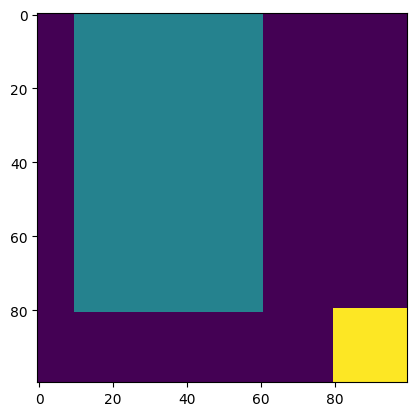

In [6]:
grid = np.zeros([LENGTH, BREADTH])

for i in range(LENGTH):
    for j in range(BREADTH):
        state = [i,j]
        if check_obstacle(state):
            # print(state)
            grid[i][j] = 5
        elif check_goal(state):
            grid[i][j] = 10
        else:
            grid[i][j] = 1

plt.imshow(grid)

In [7]:

def transition_function(state, action):
    i = state[0]
    j = state[1]
    if action == 0 and (j + ACTION_CM) < BREADTH:
        j = j + ACTION_CM
    elif action == 1 and (i - ACTION_CM) >= 0:
        i = i - ACTION_CM
    elif action == 2 and (j - ACTION_CM) >= 0:
        j = j - ACTION_CM
    elif action == 3 and (i + ACTION_CM) < LENGTH:
        i = i + ACTION_CM

    next_state = [i, j]
    return np.array(next_state)


def get_reward(state, next_state):
    if (state[0] == next_state[0]) and (state[1] == next_state[1]):
        done = False
        reward = REWARD_WALL
        # print('WALL')
    elif check_goal(next_state):
        done = True
        reward = REWARD_GOAL
        # print('GOAL')
    elif check_obstacle(next_state):
        done = False
        reward = REWARD_OBS
        # print('OBSTACLE')
    else:
        done = False
        reward = REWARD_STEP
    return done, reward

In [8]:
state_x = np.random.randint(0,100)
state_y = np.random.randint(0,100)
state = np.vstack([state_x, state_y])

state

array([[69],
       [39]])

In [9]:
# code to check transition and reward
state_x = np.random.randint(0,100, size=(1, 10))
state_y = np.random.randint(0,100, size=(1, 10))
state = np.vstack([state_x, state_y]).T
for i in state:
    action = np.random.randint(0,4)
    new_state = transition_function(i, action)
    reward, done = get_reward(i, new_state)
    print(i, ACTIONS[action], reward, new_state, done)

[61  8] L False [61  8] -10
[89 72] D False [99 72] -0.2
[50 94] L False [50 84] -0.2
[65 50] L False [65 40] -10
[54 76] U False [44 76] -0.2
[63 65] U False [53 65] -0.2
[34 24] U False [24 24] -10
[23 17] D False [33 17] -10
[29 86] D False [39 86] -0.2
[ 8 76] D False [18 76] -0.2


Episode: 0, Reward: -774.5999999999999, Epsilon: 1, x: 0, y: 76, Steps: 100 
Episode: 1, Reward: -17.799999999999983, Epsilon: 1, x: 76, y: 52, Steps: 42 
Episode: 2, Reward: -402.2000000000001, Epsilon: 1, x: 45, y: 48, Steps: 100 
Episode: 3, Reward: -55.00000000000003, Epsilon: 1, x: 75, y: 90, Steps: 32 
Episode: 4, Reward: -43.40000000000003, Epsilon: 1, x: 94, y: 49, Steps: 23 
Episode: 5, Reward: 8.4, Epsilon: 1, x: 79, y: 73, Steps: 9 
Episode: 6, Reward: -206.19999999999993, Epsilon: 1, x: 97, y: 71, Steps: 100 
Episode: 7, Reward: -13.799999999999986, Epsilon: 1, x: 45, y: 99, Steps: 22 
Episode: 8, Reward: -142.7999999999999, Epsilon: 1, x: 67, y: 11, Steps: 30 
Episode: 9, Reward: 10, Epsilon: 1, x: 94, y: 80, Steps: 1 
Episode: 10, Reward: -588.4000000000001, Epsilon: 1, x: 35, y: 54, Steps: 100 
Episode: 11, Reward: -635.2, Epsilon: 1, x: 30, y: 45, Steps: 91 
Episode: 12, Reward: -637.3999999999999, Epsilon: 1, x: 57, y: 5, Steps: 100 
Episode: 13, Reward: -235.599999999

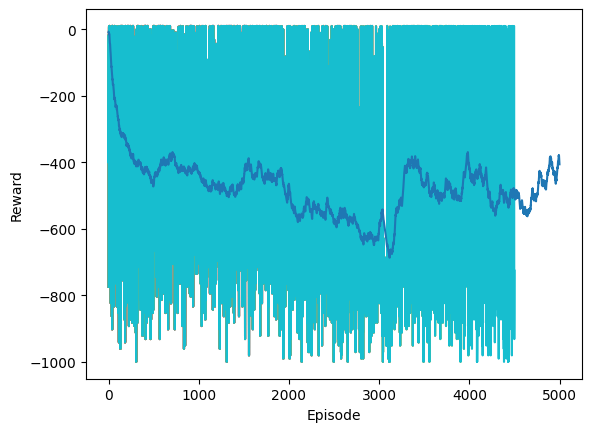

In [10]:
total_step = 0
epsilon = 1
for episode in range(MAX_EPI):
    state_x = np.random.randint(0,100)
    state_y = np.random.randint(0,100)
    state = np.array([state_x, state_y])
    done = False

    step_count = 0
    reward_sum = 0
    if (episode % epsilon_update_freq == 0 and episode>1):
        epsilon = epsilon * epsilon_decay_rate
        print(epsilon)

    path = []
    while not done:


        action = agent.choose_action(np.vstack([state_x, state_y]).T, epsilon)
        next_state = transition_function(state, action)
        done, reward = get_reward(state, next_state)
        agent.store_to_memory(state, action, reward, next_state, done)
        reward_sum += reward
        # HOw about we reduce training frequency
        loss = agent.train()
        state = next_state
        step_count += 1
        total_step += 1
        path.append(state)

        if step_count >= MAX_STEPS:
            done = True
        if total_step % weight_update_interval == 0:
            agent.weights_update()
            agent.save_model()
    if episode > (0.99*MAX_EPI):
        print(path)
    print(f"Episode: {episode}, Reward: {reward_sum}, Epsilon: {epsilon}, x: {state_x}, y: {state_y}, Steps: {step_count} ")
    reward_per_episode.append(reward_sum)
    epsilon_per_episode.append(epsilon)


    reward_avg = reward_avg + 0.01 * (reward_sum - reward_avg)

    if episode % epsilon_update_freq== 0:
        plt.plot(reward_per_episode)
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.savefig('reward_b32_lr001_relu_neuron32.png')

    # if episode % 100 == 0 and episode > 200:
    #     plt.plot(loss)
    #     plt.xlabel('Episode')
    #     plt.ylabel('Loss')
    #     plt.savefig('loss.png')
    avg_reward_per_episode.append(reward_avg)
agent.save_model()

print("Training Done")

plt.plot(avg_reward_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.savefig('reward_b32_l00001.png')
    

In [11]:
for i in range(10):
    # state = np.array([95,3])
    state_x = np.random.randint(0,10)
    state_y = np.random.randint(0,10)
    state = np.array([state_x, state_y])
    done = False

    step_count = 0

    path = []
    reward_sum = 0

    while not done:
        action = agent.choose_action(np.vstack([state[0], state[1]]).T, 0)
        next_state = transition_function(state, action)
        done, reward = get_reward(state, next_state)
        reward_sum += reward
        state = next_state
        step_count += 1
        path.append(state)

        if step_count >= MAX_STEPS:
            done = True
    print(path)

[array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1, 9]), array([1,

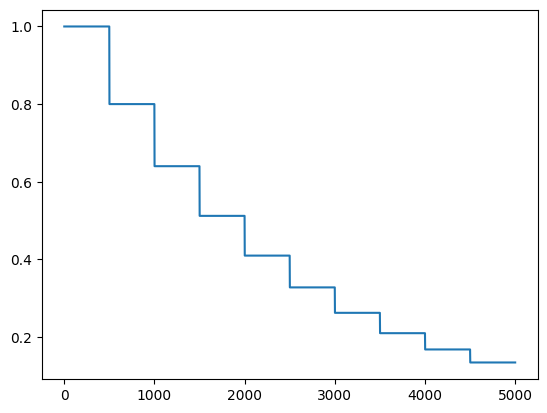

In [12]:
plt.plot(epsilon_per_episode)

[[ 4.7129707   0.45101166 -1.7279599  16.000423  ]]
[[ 4.5258846  1.0154533 -0.3806622 14.261176 ]]
[[ 4.3388004  1.5798931  0.9666352 12.521922 ]]
[[ 4.1517143  2.144329   2.3139322 10.782664 ]]
[[3.964634  2.7087727 3.6612308 9.0434065]]
[[3.7775497 3.2732134 5.0085287 7.3041487]]
[[3.5904675 3.8376503 6.3558254 5.5649023]]
[[3.4033813 4.402091  7.703124  3.8256369]]
[[3.2162952 4.9665318 9.050421  2.0863829]]
[[3.2395248 4.909211  9.901493  1.1703825]]
[[ 3.4382973  4.3329115 10.338372   0.941535 ]]
[[ 3.509058   4.07372   10.527034   0.8821554]]
[[ 3.4818344  4.057249  10.525702   0.9524832]]
[[ 3.4546108  4.040778  10.52437    1.0228109]]
[[ 3.4273853  4.0243073 10.523038   1.0931425]]
[[ 3.400158   4.0078354 10.521707   1.1634741]]
[[ 3.3729324  3.9913626 10.520375   1.2338018]]
[[ 3.345707   3.9748917 10.519044   1.3041334]]
[[ 3.3184814  3.9584208 10.517712   1.3744612]]
[[ 3.2912579  3.9419498 10.516379   1.4447889]]
[[ 3.2640343  3.925479  10.515048   1.5151167]]
[[ 3.2368088

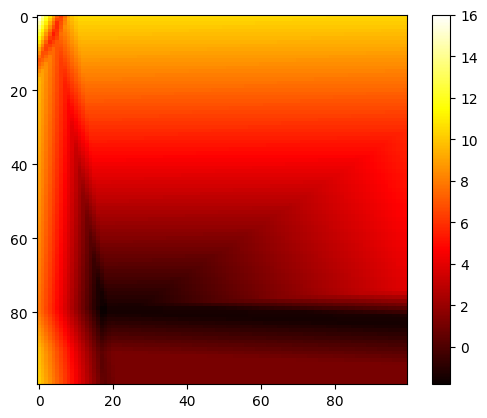

In [13]:


# network = build_network(0.01, 2, 4)
# network = keras.models.load_model("dqn_model.keras")


q_map = np.zeros([LENGTH, BREADTH])


for i in range(LENGTH):
    for j in range(BREADTH):
        q_values = agent.q_network.predict(np.array([[i,j]]), verbose=0)
        q_map[i][j] = np.max(q_values)
        print(q_values)
        

plt.imshow(q_map,  cmap='hot', interpolation='nearest')
plt.colorbar()